In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

# Predicting Lung Disease Using Deep Learning

Download the dataset for the below url

https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 5.7 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tensorflow as tf

In [5]:
main_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"

train_normal = glob(os.path.join(main_path, "train", "NORMAL", "*.jpeg"))
train_pneumonia = glob(os.path.join(main_path, "train", "PNEUMONIA", "*.jpeg"))

test_normal = glob(os.path.join(main_path, "test", "NORMAL", "*.jpeg"))
test_pneumonia = glob(os.path.join(main_path, "test", "PNEUMONIA", "*.jpeg"))

val_normal = glob(os.path.join(main_path, "val", "NORMAL", "*.jpeg"))
val_pneumonia = glob(os.path.join(main_path, "val", "PNEUMONIA", "*.jpeg"))


df_train = pd.DataFrame({
    'class': ['Normal'] * len(train_normal) + ['Pneumonia'] * len(train_pneumonia),
    'image': train_normal + train_pneumonia
})

df_test = pd.DataFrame({
    'class': ['Normal'] * len(test_normal) + ['Pneumonia'] * len(test_pneumonia),
    'image': test_normal + test_pneumonia
})

df_val = pd.DataFrame({
    'class': ['Normal'] * len(val_normal) + ['Pneumonia'] * len(val_pneumonia),
    'image': val_normal + val_pneumonia
})

In [6]:
df_train.head()

,class,image
0,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/...
1,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/...
2,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/...
3,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/...
4,Normal,/kaggle/input/chest-xray-pneumonia/chest_xray/...


In [7]:
import pandas as pd

df_train = pd.concat([df_train, df_val], axis=0)

# Reset the index 
df_train = df_train.reset_index(drop=True)

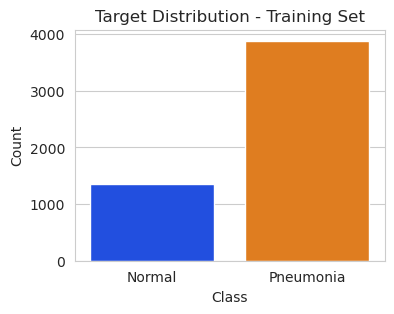

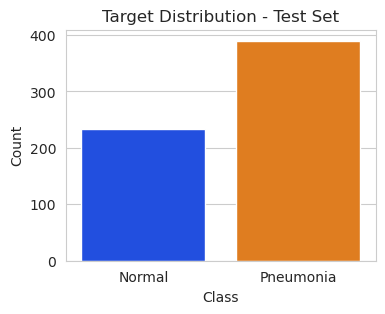

In [8]:
sns.set_palette("bright")
sns.set_style("whitegrid")

# Plotting target distribution in the training set
plt.figure(figsize=(4, 3))
sns.countplot(data=df_train, x='class')
plt.title('Target Distribution - Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Plotting target distribution in the test set
plt.figure(figsize=(4, 3))
sns.countplot(data=df_test, x='class')
plt.title('Target Distribution - Test Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

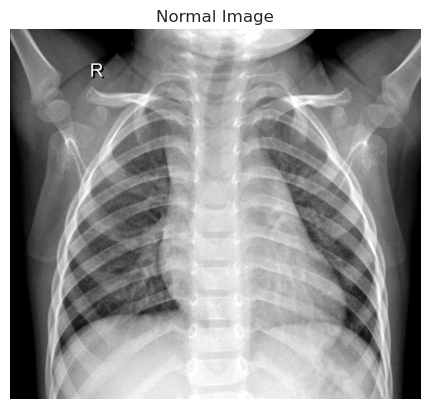

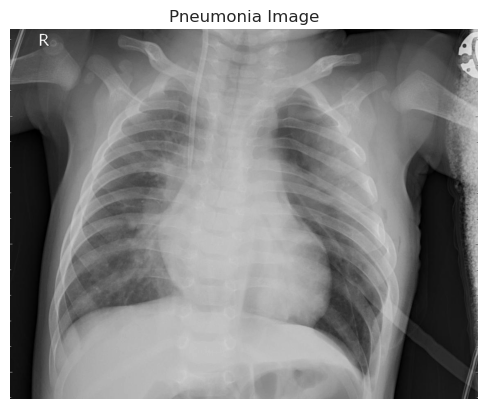

In [9]:
image_path1 = df_train['image'][1]
try:
    image1 = Image.open(image_path1)
    plt.imshow(image1, cmap='gray')
    plt.title('Normal Image')
    plt.axis('off')
    plt.show()
except (IOError, OSError) as e:
    print(f"Error opening image: {e}")

image_path2 = df_train['image'][5110]
try:
    image2 = Image.open(image_path2)
    plt.imshow(image2, cmap='gray')
    plt.title('Pneumonia Image')
    plt.axis('off')
    plt.show()
except (IOError, OSError) as e:
    print(f"Error opening image: {e}")

In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 42,
                                    stratify = df_train['class'])

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale pixel values

# Create data generators
ds_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_val = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32
)

ds_test = val_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='class',
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1
)

Found 4185 validated image filenames belonging to 2 classes.
Found 1047 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


In [24]:
from keras.applications import VGG16
from keras.layers import Input
import numpy as np

# Assuming you want to use (224, 224, 3) as the input shape
input_shape = (224, 224, 3)

# Create a Keras Input tensor with the desired shape
input_tensor = Input(shape=input_shape)

# Load the pre-trained VGG16 model (without the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the weights of the VGG16 layers so that they are not trainable
for layer in base_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [39]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout

# Assuming you have already defined your base_model and input tensor as shown before

x = base_model.output
x = Conv2D(128, (3, 3), strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)  # Add 'padding='same''

x = Conv2D(64, (3, 3), strides=1, padding='same', activation='relu')(x)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)  # Add 'padding='same''

x = Conv2D(32, (3, 3), strides=1, padding='same', activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=2, padding='same')(x)  # Add 'padding='same''

x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(units=64, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(units=1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)


In [40]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=3e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [41]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau

# Create the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, min_delta=1e-7,
                               restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_accuracy',factor = 0.2,patience = 2,
                            min_delt = 1e-7,cooldown = 0,verbose = 1) 

In [42]:

history = model.fit(ds_train,
                    batch_size = 32,
                    epochs = 10,
                    validation_data=ds_val,
                    callbacks=[early_stopping,plateau],
                    steps_per_epoch=(len(train_df)/32),
                    validation_steps=(len(val_df)/32));

Epoch 1/10


2023-07-18 13:41:15.108607: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


130/130 [==============================] - 92s 673ms/step - loss: 0.4626 - accuracy: 0.7919 - val_loss: 0.5844 - val_accuracy: 0.8577 - lr: 3.0000e-05
Epoch 2/10
130/130 [==============================] - 90s 688ms/step - loss: 0.2822 - accuracy: 0.8915 - val_loss: 0.3664 - val_accuracy: 0.9083 - lr: 3.0000e-05
Epoch 3/10
130/130 [==============================] - 89s 677ms/step - loss: 0.2260 - accuracy: 0.9164 - val_loss: 0.2457 - val_accuracy: 0.9179 - lr: 3.0000e-05
Epoch 4/10
130/130 [==============================] - 88s 673ms/step - loss: 0.1972 - accuracy: 0.9252 - val_loss: 0.1834 - val_accuracy: 0.9274 - lr: 3.0000e-05
Epoch 5/10
130/130 [==============================] - 88s 673ms/step - loss: 0.1745 - accuracy: 0.9391 - val_loss: 0.2153 - val_accuracy: 0.9074 - lr: 3.0000e-05
Epoch 6/10
130/130 [==============================] - 88s 676ms/step - loss: 0.1527 - accuracy: 0.9498 - val_loss: 0.1749 - val_accuracy: 0.9293 - lr: 3.0000e-05
Epoch 7/10
130/130 [===================

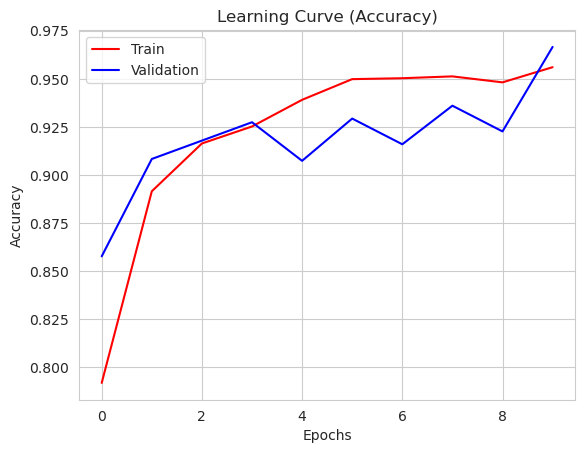

In [44]:
plt.plot(history.history['accuracy'], color='red', label='Train')
plt.plot(history.history['val_accuracy'], color='blue', label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve (Accuracy)')
plt.show()

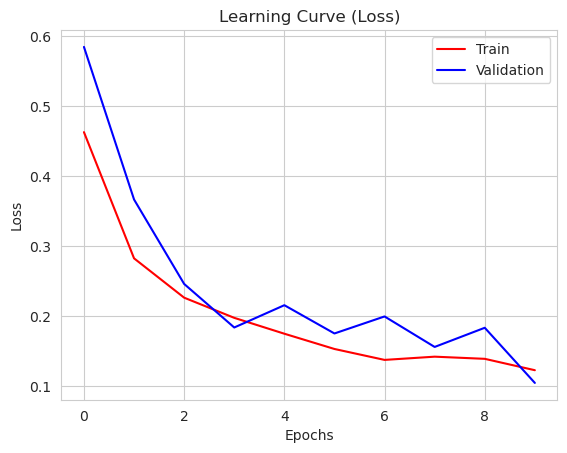

In [45]:
plt.plot(history.history['loss'], color='red', label='Train')
plt.plot(history.history['val_loss'], color='blue', label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve (Loss)')
plt.show()

In [ ]:
%%time
score = model_no.evaluate(ds_val, y__no, batch_size=128)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(ds_val,steps = int(len(ds_val)/32), verbose = 0)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(ds_test,steps = len(ds_test), verbose = 0)

# Get the predicted labels and true labels for the test dataset
test_labels = ds_test.labels
predicted_labels = model.predict(ds_test)

# Print the evaluation metrics
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

624/624 [==============================] - 6s 10ms/step
Validation Loss: 0.14245060086250305
Validation Accuracy: 0.96875
